In [2]:
import os
import wfdb
import pickle
import pandas as pd
import numpy as np
from itertools import combinations
from keras.utils import to_categorical
from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
np.set_printoptions(suppress=True)
%matplotlib inline

In [3]:
data_root = "./data/"
fs = 250
win_len = 100 #Each segment contains 100 RR-interval
note_list = ['00735','03665','04043','04936','05091','06453','08378','08405','08434','08455']

In [4]:
keys = []
for i in os.listdir(data_root):
    if not ".dat" in i:continue
    key = i.split(".")[0]
    #if key not in note_list:
    keys.append(key)
print("There are",len(keys),"records")

There are 23 records


## Make RRI dataset 

In [5]:
# ## other useful functions
def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [6]:
def find_label(rri_start,rri_end,ann_label_idx,ann_labels):
    start_label = ann_labels[ find_nearest_idx(ann_label_idx,rri_start) ] 
    end_label = ann_labels[ find_nearest_idx(ann_label_idx,rri_start) ] 
    if start_label != end_label:
        return None
    return start_label[1:]

In [20]:
def Generate_RRI_dataset(key):
    signals,fields = wfdb.rdsamp(os.path.join(data_root,key))
    ann_RRI = wfdb.rdann(os.path.join(data_root,key),extension="qrs").sample
    ann_label_index = wfdb.rdann(os.path.join(data_root,key),extension="atr").sample
    ann_labels = wfdb.rdann(os.path.join(data_root,key),extension="atr").aux_note
    
    last_rri_idx = ann_RRI[0]
    records = []
    RRI_list = []
    label_list = []
    for rri_idx in ann_RRI[1:]:
        rri_value = rri_idx-last_rri_idx
        last_rri_idx = rri_idx
        label = find_label(last_rri_idx,rri_idx,ann_label_index,ann_labels)
        RRI_list.append(rri_value)
        label_list.append(label)
    
    start = 0
    end = start + win_len
    X = []
    y = []
    start_list=[]
    end_list = []
    
    num_seg = int(len(RRI_list)/win_len)
    for i in range(num_seg):
        RRI_segment = RRI_list[start:end]
        labels = label_list[start:end]
        if (np.max(RRI_segment) > 1000):
            print("abnormal RRI segment")
            continue
        if(len(set(labels))==1 and labels[0]=="N"):
            global_label = 0
        elif (len(set(labels))==1 and labels[0]=="AFIB"):
            global_label = 1
        else:
            print("not all labels are AF or N")
            continue
        X.append(RRI_segment)
        y.append(global_label)
        start_list.append(start)
        end_list.append(end)
        start += win_len
        end = start + win_len
        
    X = np.array(X)
    y = np.array(y)
    print(key,X.shape,y.shape)
    return X,y,start_list,end_list

In [8]:
def make_balanced_and_shuffle(X,y,num_calss=2):
    one_hot_y = to_categorical(y,4)
    
    num_each_class = np.sum(one_hot_y,axis=0)
    num = int(min(num_each_class[0],num_each_class[1]))
    
    balanced_X = []
    balanced_y = []
    for class_idx in range(num_calss):
        indices = np.where(y==class_idx)
        selected_X = X[indices]
        selected_y = y[indices]
        balanced_X.append( selected_X[:num] )
        balanced_y.append( selected_y[:num])
    X = np.concatenate(balanced_X,axis=0)
    y = np.concatenate(balanced_y,axis=0)
    rand_index = np.random.permutation(len(X))
    X = X[rand_index]
    y = to_categorical(y[rand_index],num_classes=num_calss)
    return X,y

In [9]:
def normalizaiton(X_train,X_test):
    max_v = np.max(X_train)
    min_v = np.min(X_train)
    X_train = (X_train - min_v) / (max_v-min_v)
    X_test = (X_test - min_v) / (max_v-min_v)
    return X_train,X_test

In [10]:
cross = 5
num_keys_every_cross = int(len(keys)/cross)
save_dir = "./dataset_RRI"

In [12]:
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
for key in tqdm_notebook(keys):
    save_path = os.path.join(save_dir,key+".pickle")
    X,y,start,end = Generate_RRI_dataset(key)
    if len(X)==0:continue
    dataset = {"X":X,"y":y,"start":start,"end":end}
    with open(save_path,"wb") as f:
        pickle.dump(file=f,obj=dataset)

08434 (50, 100) (50,)
08378 (14, 100) (14,)
08219 (44, 100) (44,)
06426 (14, 100) (14,)
05261 (55, 100) (55,)
04746 (23, 100) (23,)
07879 (1, 100) (1,)
06453 (19, 100) (19,)
04126 (0,) (0,)
07162 (392, 100) (392,)
08455 (72, 100) (72,)
04043 (9, 100) (9,)
04908 (40, 100) (40,)
04048 (12, 100) (12,)
04936 (9, 100) (9,)
05091 (33, 100) (33,)
06995 (43, 100) (43,)
08215 (48, 100) (48,)
08405 (66, 100) (66,)
05121 (43, 100) (43,)
04015 (3, 100) (3,)
07859 (494, 100) (494,)
07910 (14, 100) (14,)



## Choose Proper test keys

In [23]:
keys = [i.split(".")[0] for i in os.listdir(save_dir) if ".pickle" in i and "cross" not in i]
print(len(keys))

22


In [24]:
label_num_dict = {}
for key in keys:
    load_path = os.path.join(save_dir,key+".pickle")
    if not os.path.exists(load_path):continue
    with open(load_path,"rb") as f:
        dataset=pickle.load(f)
    y = to_categorical(dataset["y"],num_classes=2)
    label_num_dict[key] = np.sum(y,axis=0)

In [25]:
for test_key_idx in list(combinations(range(len(keys)), 3)):
    test_set_num = np.array([0.,0.])
    train_set_num = np.array([0.,0.])
    for i,key in enumerate(keys):
        if i in test_key_idx:
            test_set_num += label_num_dict[key]
        else:
            train_set_num += label_num_dict[key]
    if np.min(test_set_num)>125 and np.min(train_set_num)>2500:
        print(test_key_idx,test_set_num,train_set_num)
    

In [26]:
test_key_indices = [
    (2,4,12),
    (3,9,11),
    (9,12,17),
    (6,16,17),
    (2,18,19)
]

In [27]:
cross_valid_keys={}
for i in range(len(test_key_indices)):
    test_keys = []
    indices = test_key_indices[i]
    for idx in indices:
        test_keys.append(keys[idx])
    cross_valid_keys[i] = test_keys
print(cross_valid_keys)

{0: ['08378', '08219', '04936'], 1: ['08215', '04043', '08455'], 2: ['04043', '04936', '04908'], 3: ['07162', '05091', '04908'], 4: ['08378', '06995', '05261']}


## already know test keys

In [28]:
cross_valid_keys = {
    0:['08434', '04746', '07162'],
    1:['08219', '07162', '05091'],
    2:['07879', '07162', '08455'],
    3:['05261', '06453', '07162'],
    4:['07162', '04043', '08405']
}

## Generate 5-cross dataset

In [29]:
def load_dataset(key):
    load_path = os.path.join(save_dir,key+".pickle")
    with open(load_path,"rb") as f:
        dataset=pickle.load(f)
    return dataset["X"],dataset["y"]

In [30]:
for cross_idx in range(cross):
    test_keys = cross_valid_keys[cross_idx]
    save_path = os.path.join(save_dir,"dataset-cross"+str(cross_idx)+".pickle")
    print(test_keys)
    X_train = []
    X_test = []
    y_train = []
    y_test = []
    for key in keys:
        X,y = load_dataset(key)
        if(len(X)==0):continue
        if key in test_keys:
            X_test.append(X)
            y_test.append(y)
        else:
            X_train.append(X)
            y_train.append(y)
    
    X_train = np.expand_dims(np.concatenate(X_train,axis=0),axis=2)
    y_train = np.concatenate(y_train,axis=0)
    X_test = np.expand_dims(np.concatenate(X_test,axis=0),axis=2)
    y_test = np.concatenate(y_test,axis=0)
    
    
    X_train,y_train = make_balanced_and_shuffle(X_train,y_train)
    X_test,y_test = make_balanced_and_shuffle(X_test,y_test)    
    X_train,X_test = normalizaiton(X_train,X_test)
    
    print("X_train:",X_train.shape)
    print("y_train:",y_train.shape)
    print("X_test:",X_test.shape)
    print("y_test:",y_test.shape)
    print("\n")
    dataset = {"test_key":test_keys,"X_train":X_train,"y_trian":y_train,"X_test":X_test,"y_test":y_test}
    with open(save_path,"wb") as f:
        pickle.dump(obj=dataset,file=f)

['08434', '04746', '07162']
X_train: (964, 100, 1)
y_train: (964, 2)
X_test: (146, 100, 1)
y_test: (146, 2)


['08219', '07162', '05091']
X_train: (956, 100, 1)
y_train: (956, 2)
X_test: (154, 100, 1)
y_test: (154, 2)


['07879', '07162', '08455']
X_train: (964, 100, 1)
y_train: (964, 2)
X_test: (146, 100, 1)
y_test: (146, 2)


['05261', '06453', '07162']
X_train: (962, 100, 1)
y_train: (962, 2)
X_test: (148, 100, 1)
y_test: (148, 2)


['07162', '04043', '08405']
X_train: (960, 100, 1)
y_train: (960, 2)
X_test: (150, 100, 1)
y_test: (150, 2)




(array([  21., 2427., 8790., 2288., 1107.,  322.,   37.,    4.,    3.,
           1.]),
 array([0.00235849, 0.12948113, 0.25660377, 0.38372642, 0.51084906,
        0.6379717 , 0.76509434, 0.89221698, 1.01933962, 1.14646226,
        1.27358491]),
 <a list of 10 Patch objects>)

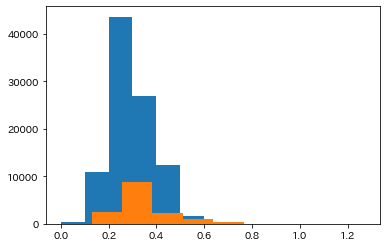

In [31]:
plt.hist(np.reshape(X_train,newshape=(-1,1)))
plt.hist(np.reshape(X_test,newshape=(-1,1)))